In [12]:
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'

som_model = get_yolo_model(model_path='weights/icon_detect_v1_5/best.pt')

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [3]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
# caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [15]:
# reload utils
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
image_path = 'imgs/windows_home.png'
image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = 'imgs/word.png'
# image_path = 'imgs/excel.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.5}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1919, 1079)

image 1/1 /home/yadonglu/OmniParser/imgs/word.png: 736x1280 138 0s, 7.5ms
Speed: 5.4ms preprocess, 7.5ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)


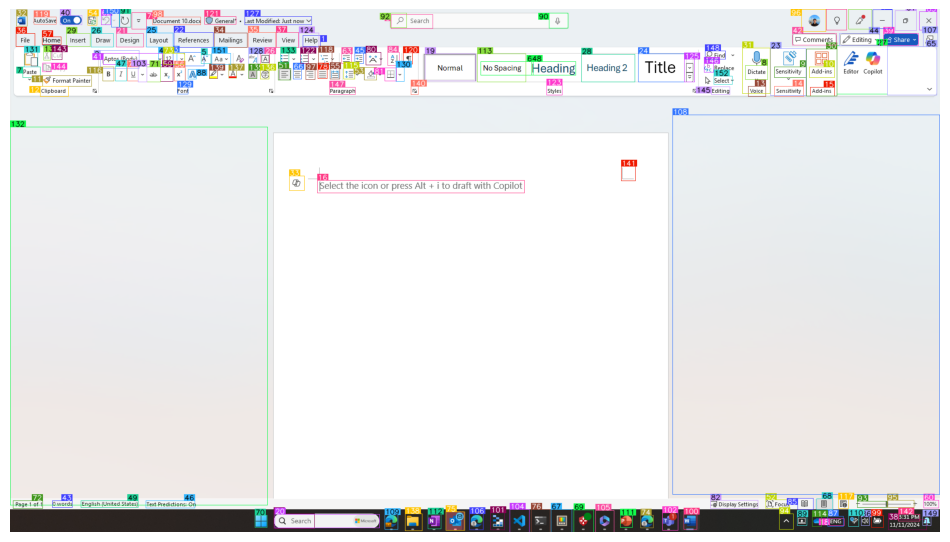

In [16]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(12,12))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [17]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,ID
0,text,"[0.4095883369445801, 0.011121409013867378, 0.4...",False,O Search,0
1,text,"[0.31474727392196655, 0.05004633963108063, 0.3...",False,Help,1
2,text,"[0.09692548215389252, 0.07877664268016815, 0.1...",False,Aptos (Body),2
3,text,"[0.1750911921262741, 0.08248378336429596, 0.20...",False,A A,3
4,text,"[0.15945805609226227, 0.08433734625577927, 0.1...",False,12,4
...,...,...,...,...,...
148,icon,"[0.7477767467498779, 0.07976064831018448, 0.76...",True,Find.,148
149,icon,"[0.9812965989112854, 0.970005989074707, 0.9904...",True,Notifications,149
150,icon,"[0.10905546694993973, 0.00921074952930212, 0.1...",True,Expand to show more options,150
151,icon,"[0.21692517399787903, 0.08472321182489395, 0.2...",True,Superscript,151


In [18]:
df[df['ID'] == 47]

,type,bbox,interactivity,content,ID
47,icon,"[0.11308763176202774, 0.10972367227077484, 0.1...",True,Italic,47
